In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
img_size=256
bt_size=32
ch=3
epochs=50

In [3]:
training_brain_data=tf.keras.preprocessing.image_dataset_from_directory(
    'Training',
    shuffle= True,
    image_size=(img_size, img_size),
    batch_size=bt_size
)

Found 1648 files belonging to 2 classes.


In [4]:
testing_brain_data=tf.keras.preprocessing.image_dataset_from_directory(
    'Testing',
    shuffle= True,
    image_size=(img_size, img_size),
    batch_size=bt_size
)

Found 215 files belonging to 2 classes.


In [5]:
training_brain_class_names=training_brain_data.class_names

In [6]:
testing_brain_class_names=testing_brain_data.class_names

In [7]:
len(training_brain_data)

52

In [8]:
len(testing_brain_data)

7

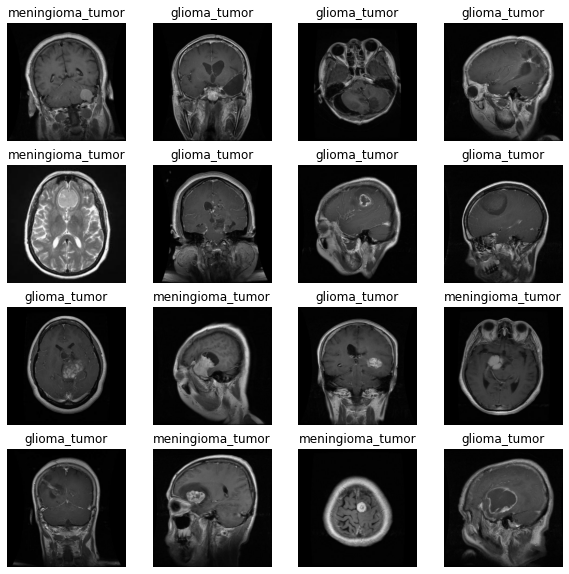

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in training_brain_data.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(training_brain_class_names[label_batch[i]])
        plt.axis('off')

In [10]:
def testing_split_df(testing_brain_data, val_split=0.2, test_split=0.8, shuffle=True, shuffle_size=10000):
    ds_size=len(testing_brain_data)
    if shuffle:
        testing_brain_data=testing_brain_data.shuffle(shuffle_size, seed=12)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)
    
    val_brain_data=testing_brain_data.take(val_size)
    test_brain_data=testing_brain_data.skip(val_size)
    
    return val_brain_data, test_brain_data

In [11]:
val_brain_data, test_brain_data= testing_split_df(testing_brain_data)

In [12]:
len(val_brain_data)

1

In [13]:
len(test_brain_data)

6

In [14]:
train_brain_data=training_brain_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_brain_data= val_brain_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_brain_data= test_brain_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape= (bt_size, img_size, img_size, ch)
n_classes=2

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history=model.fit(
    train_brain_data,
    epochs=epochs,
    batch_size=bt_size,
    verbose=1,
    validation_data=val_brain_data
)

Epoch 1/50
52/52 [==============================] - 119s 2s/step - loss: 0.6814 - accuracy: 0.5419 - val_loss: 0.8283 - val_accuracy: 0.6250
Epoch 2/50
52/52 [==============================] - 99s 2s/step - loss: 0.5237 - accuracy: 0.7403 - val_loss: 0.8836 - val_accuracy: 0.5938
Epoch 3/50
52/52 [==============================] - 94s 2s/step - loss: 0.4449 - accuracy: 0.7913 - val_loss: 1.5142 - val_accuracy: 0.6250
Epoch 4/50
52/52 [==============================] - 678s 13s/step - loss: 0.4510 - accuracy: 0.7822 - val_loss: 1.6627 - val_accuracy: 0.6562
Epoch 5/50
52/52 [==============================] - 137s 3s/step - loss: 0.4442 - accuracy: 0.7973 - val_loss: 1.2906 - val_accuracy: 0.6250
Epoch 6/50
52/52 [==============================] - 125s 2s/step - loss: 0.4045 - accuracy: 0.8161 - val_loss: 1.2920 - val_accuracy: 0.6562
Epoch 7/50
52/52 [==============================] - 118s 2s/step - loss: 0.4484 - accuracy: 0.7809 - val_loss: 1.2766 - val_accuracy: 0.6875
Epoch 8/50
52/

In [21]:
scores=model.evaluate(test_brain_data)

6/6 [==============================] - 3s 375ms/step - loss: 2.2821 - accuracy: 0.6885


In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

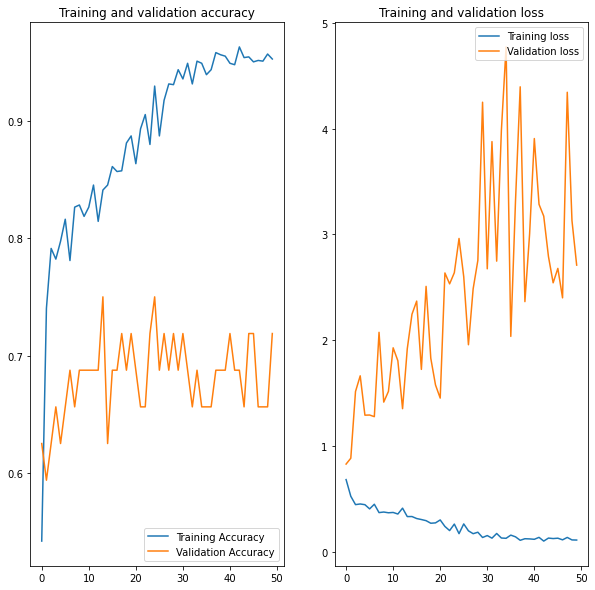

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training loss')
plt.plot(range(epochs), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

actual label: meningioma_tumor
1/1 [==============================] - 0s 423ms/step
predicted label: meningioma_tumor


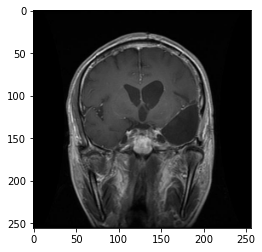

In [30]:
for images_batch, labels_batch in test_brain_data.take(1):
    
    first_image=image_batch[1].numpy().astype('uint8')
    first_label=labels_batch[1].numpy()
    
    plt.imshow(first_image)
    print('actual label:', testing_brain_class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print('predicted label:', testing_brain_class_names[np.argmax(batch_prediction[1])])

In [31]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=testing_brain_class_names[np.argmax(batch_prediction[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


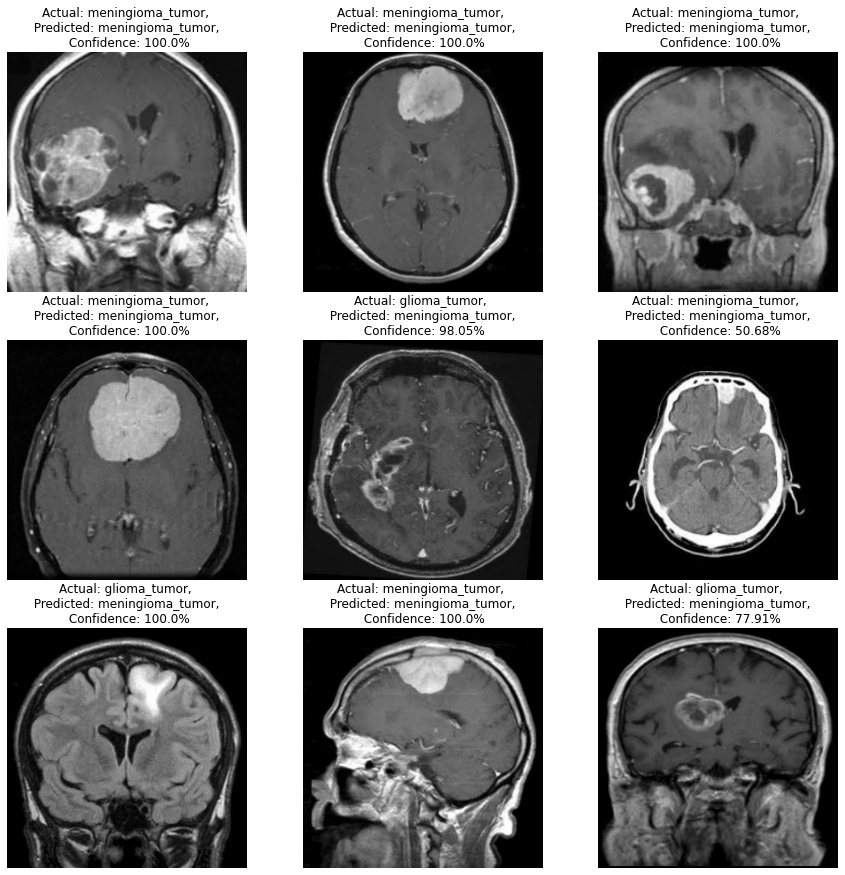

In [51]:
plt.figure(figsize=(15,15))
for images, labels in test_brain_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=testing_brain_class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%')
        
        plt.axis('off')

In [53]:
model_version=1
model.save(f'C:/Users/Rifatul Islam Himel/Downloads/project/models/{model_version}')

INFO:tensorflow:Assets written to: C:/Users/Rifatul Islam Himel/Downloads/project/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/Rifatul Islam Himel/Downloads/project/models/1\assets
